This notebook is only for developing, training, and saving the model. For evaluating the model, check `evaluate.ipynb`.

# Datasets

Run this `gcsfuse` cell if you can't list the folders inside of "/gcs"

In [1]:
!gcsfuse --implicit-dirs "~/gcs"

I1129 04:43:41.624666 2023/11/29 04:43:41.624635 Start gcsfuse/0.42.5 (Go version go1.20.3) for app "" using mount point: /home/jupyter/gcs
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithConn: Mount: mount: running /usr/bin/fusermount: exit status 1


When using GCS buckets, use "/gcs" instead of "gs://"

In [2]:
#from sklearn.model_selection import train_test_split

dataset_path = "/home/jupyter/gcs/serena-shsw-datasets"
train_path = dataset_path + "/FER-SERENA/train/train"
test_path = dataset_path + "/FER-SERENA/test/test"
validation_path = dataset_path + "/FER-SERENA/valid/validation"

# Output directory contents
!echo "Train"
!ls {train_path}
!echo "Test"
!ls {test_path}
!echo "Valid"
!ls {validation_path}

Train
angry  disgust	fear  happy  neutral  sad  surprise
Test
angry  disgust	fear  happy  neutral  sad  surprise
Valid
angry  disgust	fear  happy  neutral  sad  surprise


# Import Library

In [3]:
shape_x = 48
shape_y = 48

In [4]:
import numpy as np
import os
from PIL import Image

def read_images_from_folder(folder_path):
    images = []
    labels = []
    for idx, emotion_folder in enumerate(os.listdir(folder_path)):
        if os.path.isdir(os.path.join(folder_path, emotion_folder)):
            emotion_dir = os.path.join(folder_path, emotion_folder)
            for filename in os.listdir(emotion_dir):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(emotion_dir, filename)
                    img = Image.open(img_path).resize((48, 48))  # Resize images as needed
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(idx)  # Append label corresponding to the image
    images = np.array(images)
    labels = np.array(labels)
    images = np.expand_dims(images, axis=-1)  # Add a channel dimension
    labels = np.expand_dims(labels, axis=-1)  # Reshape labels
    return images, labels

# Assuming you have defined train_path, test_path, and validation_path

# Read images and labels for train, test, and validation sets
train_images, train_labels = read_images_from_folder(train_path)
test_images, test_labels = read_images_from_folder(test_path)
validation_images, validation_labels = read_images_from_folder(validation_path)

# Normalize pixel values to range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

# Print shapes of data arrays
print("Shape of train_images and train_labels:", train_images.shape, train_labels.shape)
print("Shape of test_images and test_labels:", test_images.shape, test_labels.shape)
print("Shape of validation_images and validation_labels:", validation_images.shape, validation_labels.shape)


Shape of train_images and train_labels: (22968, 48, 48, 1) (22968, 1)
Shape of test_images and test_labels: (7178, 48, 48, 1) (7178, 1)
Shape of validation_images and validation_labels: (5741, 48, 48, 1) (5741, 1)


In [5]:
shape_x = 48
shape_y = 48
nRows, nCols, nDims = train_images.shape[1:]  # Menggunakan train_images
input_shape = (nRows, nCols, nDims)
classes = np.unique(train_labels)
nClasses = len(classes)

In [6]:
from tensorflow.keras.utils import to_categorical
# Change to float datatype (if not already float32)
train_data = train_images.astype('float32')
test_data = test_images.astype('float32')

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

2023-11-29 04:47:57.947450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-29 04:47:57.947526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images
nSamples, nRows, nCols = train_images.shape[0], train_images.shape[1], train_images.shape[2]
nDims = 1  # Assuming the images are grayscale
input_shape = (nRows, nCols, nDims)
print('Input shape : ', input_shape)


Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]
Input shape :  (48, 48, 1)


In [8]:
class_labels = sorted(os.listdir(train_path ))

print("Class labels:", class_labels)

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'neutral' , 5:'sad', 6:'Surprise'}
    return(labels.get(argument, "Invalid emotion"))


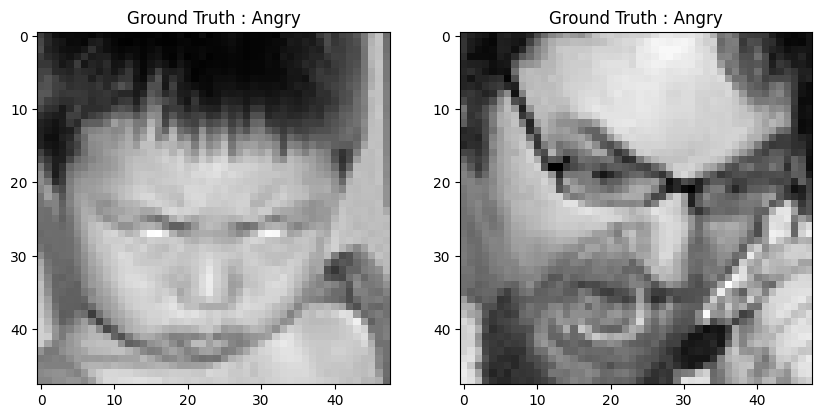

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])

# Menampilkan gambar pertama dalam data latih (train_images) dan labelnya (train_labels)
plt.subplot(121)
plt.imshow(np.squeeze(train_images[0], axis=2), cmap='gray')  # Menggunakan train_images
plt.title("Ground Truth : {}".format(get_label(int(train_labels[0]))))  # Menggunakan train_labels

# Menampilkan gambar pertama dalam data uji (test_images) dan labelnya (test_labels)
plt.subplot(122)
plt.imshow(np.squeeze(test_images[0], axis=2), cmap='gray')  # Menggunakan test_images
plt.title("Ground Truth : {}".format(get_label(int(test_labels[0]))))  # Menggunakan test_labels

plt.show()


In [11]:
# Cek jumlah sampel per kelas pada data latih
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

# Cek jumlah sampel per kelas pada data uji
unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 3196, 1: 349, 2: 3278, 3: 5772, 4: 3972, 5: 3864, 6: 2537}
{0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1233, 5: 1247, 6: 831}


In [12]:
import tensorflow as tf
print(tf.__version__)


2.9.0


In [13]:
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. Oversampling using SMOTE
smote = SMOTE(random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images.reshape(-1, 48*48), train_labels)
train_images_resampled = train_images_resampled.reshape(-1, 48, 48)


In [16]:
# Flatten train_labels if needed
flat_train_labels = train_labels.flatten() if train_labels.ndim > 1 else train_labels

# Compute class counts
class_counts = np.bincount(flat_train_labels)
total_samples = np.sum(class_counts)

# Calculate class weights
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert to dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define augmented data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

batch_size = 18  
# Calculate the number of batches
num_batches = len(train_images_resampled) // batch_size

# Initialize empty lists to store augmented data
augmented_images = []
augmented_labels = []

# Perform augmentation in a loop
for i in range(num_batches):
    x_batch = train_images_resampled[i * batch_size: (i + 1) * batch_size]
    y_batch = train_labels_one_hot[i * batch_size: (i + 1) * batch_size]
    
    # Add channel dimension explicitly
    x_batch_with_channel = np.expand_dims(x_batch, axis=-1)
    
    # Generate augmented images
    x_augmented = datagen.flow(x_batch_with_channel, batch_size=batch_size, shuffle=False)
    augmented_images_batch = next(x_augmented)
    
    # Append augmented images to the list
    augmented_images.append(augmented_images_batch)
    
    # Repeat the labels to match the number of augmented images generated
    if len(y_batch) > 0:
        num_repeats = len(augmented_images_batch) // len(y_batch)
        augmented_labels_batch = np.tile(y_batch, (num_repeats, 1))
        augmented_labels.append(augmented_labels_batch)
    else:
        # Handle the case where y_batch has zero length
        # You might want to skip or handle this differently based on your specific use case
        pass

# Concatenate augmented data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


In [19]:
bucket_name = 'serena-shsw-datasets'
file_name = 'haarcascade_frontalface_default.xml'

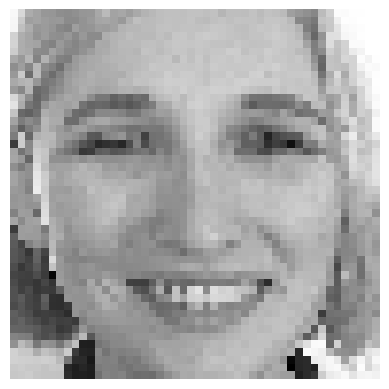

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to extract facial features
def extract_face_features(faces, target_shape=(48, 48)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    for det in detected_face:
        x, y, w, h = det
        horizontal_offset = int(0.075 * w)
        vertical_offset = int(0.05 * h)

        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        # Resize the extracted face to the target shape
        new_extracted_face = cv2.resize(extracted_face, target_shape)
        new_extracted_face = new_extracted_face.astype(np.float32) / 255.0  # Normalize pixel values
        new_face.append(new_extracted_face)
    
    return new_face

# Function to detect faces
def detect_face(frame):
    cascPath = 'haarcascade_frontalface_default.xml'  # Path to the XML file
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return gray, detected_faces

# Load an image
image_path = '/home/jupyter/gcs/serena-shsw-datasets/FER-SERENA/predict/example2.jpg'
frame = cv2.imread(image_path)

# Detect faces in the image
gray, faces = detect_face(frame)

# Extract features from detected faces
extracted_faces = extract_face_features((gray, faces))

# Display or use the extracted faces as needed
for face in extracted_faces:
    plt.imshow(face, cmap='gray')
    plt.axis('off')
    plt.show()


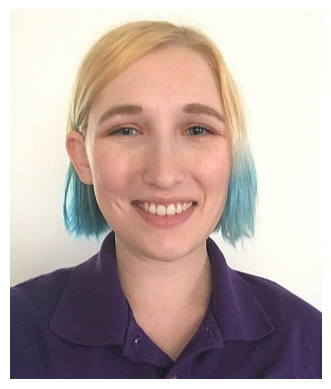

In [21]:
trump = '/home/jupyter/gcs/serena-shsw-datasets/FER-SERENA/predict/example2.jpg'
trump_face = cv2.imread(trump)  # Read the image without color conversion
trump_face = cv2.cvtColor(trump_face, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

plt.imshow(trump_face)
plt.axis('off')  # Hide axis ticks and labels
plt.show()


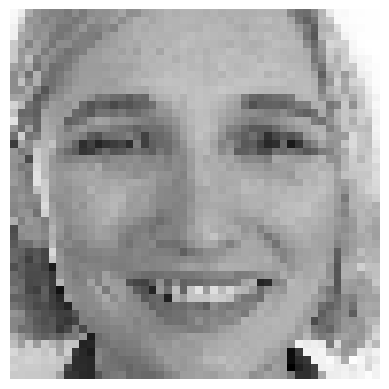

In [22]:
# Assuming detect_face is defined somewhere in your code or imported from a library
gray_trump_face, face_coords = detect_face(trump_face)  # Extract grayscale image and face coordinates
face = extract_face_features((gray_trump_face, face_coords))[0]  # Extract facial features from the grayscale image

plt.imshow(face, cmap='gray')  # Display the extracted facial features
plt.axis('off')  # Hide axis ticks and labels
plt.show()


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten

# Define the input shape
input_shape = (48, 48, 1)  # Assuming grayscale images with dimensions 48x48

# Create the model function
def createModel3():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

# Create the model instance
model = createModel3()

# Compile the model (add optimizer, loss function, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary to check dimensions
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 20)        200       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 30)        5430      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 30)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 30)       120       


2023-11-29 05:09:10.220501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2023-11-29 05:09:10.220556: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 05:09:10.220590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emotion-detector-nb): /proc/driver/nvidia/version does not exist
2023-11-29 05:09:10.220923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 30)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 40)        10840     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 50)        18050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 50)       200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 50)        0         
          

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_images/model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False) 

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 1

# Fit the model on the batches generated by datagen.flow().
# Reshape the data to include the channel dimension
train_data_with_channels = np.expand_dims(train_data, axis=-1)
test_data_with_channels = np.expand_dims(test_data, axis=-1)

# Then use ImageDataGenerator
history = model.fit_generator(
    datagen.flow(train_data_with_channels, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data_with_channels.shape[0] / float(batch_size))),
    epochs=epochs,
    validation_data=(test_data_with_channels, test_labels_one_hot)
)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


 3/90 [>.............................] - ETA: 2:15 - loss: 2.3166 - accuracy: 0.1667

KeyboardInterrupt: 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input  # Import Input layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3

# PRE-PROCESSING DATA

In [12]:
# Define ImageDataGenerator for data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
img_size = (224, 224)
batch_size = 64

train_generator = train_datagen.flow_from_directory(
    training_dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
base_model = MobileNetV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model.summary()

# Create Model

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)       

# Data Generating

In [15]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    # epochs=200,
    epochs=1,
)

Epoch 1/200
  2/359 [..............................] - ETA: 19:53 - loss: 2.9971 - accuracy: 0.1328

KeyboardInterrupt: 

# Saving Model

Vertex AI expects the model artifacts to be saved in `BASE_OUTPUT_DIRECTORY/model/` when you want to train a new version of a model

In [1]:
saved_model_path = dataset_path + "/models/serena-emotion-detector/model"

# Do not uncomment this line, it will be done by setup.sh
#model.save(saved_model_path)

NameError: name 'dataset_path' is not defined

After saving, use `evaluate.ipynb` to evaluate the model after loading the artifacts.